In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics

/kaggle/input/tabular-playground-series-nov-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-nov-2021/train.csv
/kaggle/input/tabular-playground-series-nov-2021/test.csv


# Importing competition data

In [2]:
df_train = pd.read_csv("../input/tabular-playground-series-nov-2021/train.csv")
df_test = pd.read_csv("../input/tabular-playground-series-nov-2021/test.csv")
df_train

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
0,0,0.106643,3.594370,132.8040,3.184280,0.081971,1.18859,3.732380,2.266270,2.099590,...,1.098620,0.013331,-0.011715,0.052759,0.065400,4.211250,1.978770,0.085974,0.240496,0
1,1,0.125021,1.673360,76.5336,3.378250,0.099400,5.09366,1.275620,-0.471318,4.545940,...,3.460170,0.017054,0.124863,0.154064,0.606848,-0.267928,2.577860,-0.020877,0.024719,0
2,2,0.036330,1.497470,233.5460,2.194350,0.026914,3.12694,5.056870,3.849460,1.801870,...,4.883000,0.085222,0.032396,0.116092,-0.001688,-0.520069,2.141120,0.124464,0.148209,0
3,3,-0.014077,0.246000,779.9670,1.890640,0.006948,1.53112,2.698000,4.517330,4.503320,...,3.474390,-0.017103,-0.008100,0.062013,0.041193,0.511657,1.968600,0.040017,0.044873,0
4,4,-0.003259,3.715420,156.1280,2.147720,0.018284,2.09859,4.154920,-0.038236,3.371450,...,1.910590,-0.042943,0.105616,0.125072,0.037509,1.043790,1.074810,-0.012819,0.072798,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,0.043008,1.640550,1375.8900,1.087030,0.839580,1.69362,3.843520,1.108250,1.505390,...,1.552280,0.080317,0.017643,0.225133,0.073179,4.436510,1.739330,0.049038,0.065804,1
599996,599996,0.137048,4.826860,-99.6478,0.985289,0.037712,3.30370,2.471790,5.942130,0.875148,...,1.345210,0.092457,0.081926,0.234041,0.041383,3.873990,1.870100,0.162313,0.085662,0
599997,599997,1.316220,0.502062,66.2360,2.233020,0.060038,3.77371,2.655340,3.155890,1.055020,...,2.181150,0.032708,0.109668,0.027466,0.061931,-0.383329,0.922113,0.084864,0.052635,0
599998,599998,0.511918,3.827470,777.8720,0.285914,0.520157,2.76285,2.522200,1.561360,1.971140,...,0.366702,0.070943,0.071452,-0.038071,0.038829,-0.122888,3.107790,0.061333,0.004179,1


In [3]:
df_train.nunique()

id        600000
f0        516483
f1        409963
f2        485459
f3        398271
           ...  
f96       407424
f97       399620
f98       505994
f99       499969
target         2
Length: 102, dtype: int64

# Features dtype consuming a lot of memory so need to be reduced

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Columns: 102 entries, id to target
dtypes: float64(100), int64(2)
memory usage: 466.9 MB


In [5]:
#reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 231.74 Mb (50.4% reduction)
Mem. usage decreased to 208.05 Mb (50.0% reduction)


> # EDA

In [6]:
df_train.isnull().sum()

id        0
f0        0
f1        0
f2        0
f3        0
         ..
f96       0
f97       0
f98       0
f99       0
target    0
Length: 102, dtype: int64

In [7]:
check = pd.DataFrame(df_train,columns=df_train.columns)
duplicate = check[check.duplicated(keep='last')]  
duplicate

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target


In [8]:
def Unique_features(df):
    Columns = df.columns
    for c in Columns:
        Uni = df[c].unique()
        if len(Uni) <= round(df.shape[0]*0.5):
            print(' ')
            print (c +':' +str(len(df[c].unique())))
            print (Uni)
        else:
            print(' ')
            print(str(c) + ' is cont')
Unique_features(df_train)  

 
id is cont
 
f0 is cont
 
f1 is cont
 
f2 is cont
 
f3 is cont
 
f4 is cont
 
f5 is cont
 
f6 is cont
 
f7 is cont
 
f8 is cont
 
f9 is cont
 
f10 is cont
 
f11 is cont
 
f12 is cont
 
f13 is cont
 
f14 is cont
 
f15 is cont
 
f16 is cont
 
f17 is cont
 
f18 is cont
 
f19 is cont
 
f20 is cont
 
f21 is cont
 
f22 is cont
 
f23 is cont
 
f24 is cont
 
f25 is cont
 
f26 is cont
 
f27 is cont
 
f28 is cont
 
f29 is cont
 
f30 is cont
 
f31 is cont
 
f32 is cont
 
f33 is cont
 
f34 is cont
 
f35 is cont
 
f36 is cont
 
f37 is cont
 
f38 is cont
 
f39 is cont
 
f40 is cont
 
f41 is cont
 
f42 is cont
 
f43 is cont
 
f44 is cont
 
f45 is cont
 
f46 is cont
 
f47 is cont
 
f48 is cont
 
f49 is cont
 
f50 is cont
 
f51 is cont
 
f52 is cont
 
f53 is cont
 
f54 is cont
 
f55 is cont
 
f56 is cont
 
f57 is cont
 
f58 is cont
 
f59 is cont
 
f60 is cont
 
f61 is cont
 
f62 is cont
 
f63 is cont
 
f64 is cont
 
f65 is cont
 
f66 is cont
 
f67 is cont
 
f68 is cont
 
f69 is cont
 
f70 is cont
 
f

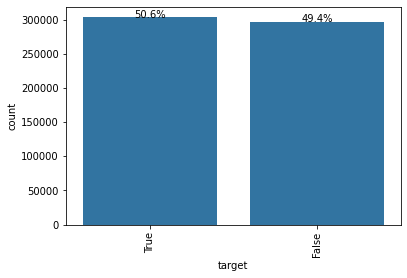

In [9]:
def bar_chart(df,feature):
    #Preparing parameters for plot
    type_counts = df[feature].value_counts()
    type_order = type_counts.index
    base_color = sns.color_palette()[0]
    n = df_copy[feature].value_counts().sum()
    #Plot
    sns.countplot(data=df, x= feature, color=base_color, order=type_order);

    type_counts = df[feature].value_counts()
    
    #Labeling
    locs, labels = plt.xticks(rotation=90) 
    for loc, label in zip(locs, labels):
        count = type_counts[label.get_text()]
        pct_string = '{:0.1f}%'.format(100*count/n)
        plt.text(loc, count+2, pct_string, ha = 'center', color = 'black')
df_copy = df_train.copy()
df_copy['target'] = df_train['target'].astype(bool).astype(str)
bar_chart(df_copy,'target')   

In [10]:
df_train.describe()  

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,target
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,...,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,299999.500000,0.306512,2.497594,306.640411,2.647901,0.177850,2.556831,2.699653,2.571597,2.538332,...,2.444480,0.155260,0.059406,0.144932,0.106420,2.547832,2.590189,0.158881,0.123050,0.506010
std,173205.225094,0.522419,1.553887,551.701843,1.544408,0.417466,1.562393,1.563862,1.549217,1.532848,...,1.542386,0.548227,0.119386,0.461895,0.209071,1.558289,1.524971,0.436124,0.264834,0.499964
min,0.000000,-3.797450,-1.223960,-1842.530029,-1.368560,-3.206210,-1.169770,-1.059310,-1.281970,-1.242020,...,-1.217700,-9.761770,-4.666240,-3.101500,-1.276540,-1.584740,-1.254730,-3.993500,-2.783380,0.000000
25%,149999.750000,0.026222,1.186237,43.573400,1.442027,0.019709,1.261037,1.385820,1.333848,1.292163,...,1.214177,0.018904,0.024483,0.017055,0.025461,1.247887,1.348078,0.013536,0.018105,0.000000
50%,299999.500000,0.097788,2.516500,133.626007,2.634130,0.061586,2.590425,2.801255,2.557985,2.475880,...,2.386845,0.068906,0.056649,0.063439,0.062151,2.601940,2.682090,0.058058,0.058471,1.000000
75%,449999.250000,0.397184,3.787630,302.262238,3.907640,0.112712,3.813662,3.996913,3.823450,3.804360,...,3.693873,0.125165,0.088162,0.113114,0.102016,3.820665,3.839520,0.110718,0.104872,1.000000
max,599999.000000,8.781500,6.226720,6119.279785,6.521150,8.265470,6.515070,6.586780,6.258770,6.389670,...,6.573890,18.412800,10.211800,8.623270,3.657220,6.254360,6.145300,10.767000,5.988110,1.000000


In [11]:
X, X_hold_out, y, y_hold_out = train_test_split(df_train.drop(['id','target'], axis=1), df_train['target'], random_state=0, test_size = 0.0297,stratify=df_train['target'])

In [12]:
#feature scaling to obtain 0 mean and 1 varianc 
def feature_scaling(X):
    X_copy = X.copy()
    mean = np.sum(X,0)/X.shape[0]
    X-=mean
    p = [2] * X.shape[1]
    X = X.pow( p, axis = 'columns')
    standard_deviation = np.sqrt(np.sum(X,0)/X.shape[0])
    X_copy = (X_copy-mean)/standard_deviation
    return (X_copy,mean , standard_deviation)
#X , mean , std  = feature_scaling(X)
X , mean , std  = feature_scaling(X)

In [13]:
X_hold_out = (X_hold_out - mean)/std
ID = df_test['id']
df_test.drop(columns = ['id'] , axis = 1 , inplace = True)
df_test = (df_test-mean)/std

# Modeling

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size = 0.0297,stratify=y)

In [15]:
modelx = XGBClassifier(base_score=0.5, booster='gbtree' ,colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate= 0.75365952,
              max_delta_step=0, max_depth= 2 , min_child_weight=0,
              monotone_constraints='()', n_estimators= 300 , n_jobs=-1,
              num_parallel_tree=1, random_state=42,
              reg_alpha= 0.1, reg_lambda= 0.5, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=10, verbosity=None)
modelx.fit(X_train, y_train)
y_pred = modelx.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting valid is: '+str(accuracy)+'%')
y_pred = modelx.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')
#model.fit(X, y)

model accuracy on predicting valid is: 70.14631889422243%
model accuracy on predicting train is: 71.21877041330244%


> # XGB AUC Score

In [16]:
'''y_XGB_prob1 = modelx.predict_proba(X_valid)
y_XGB_prob_hold = modelx.predict_proba(X_hold_out)'''

'y_XGB_prob1 = modelx.predict_proba(X_valid)\ny_XGB_prob_hold = modelx.predict_proba(X_hold_out)'

In [17]:
from sklearn.metrics import roc_auc_score
'''auc = roc_auc_score(y_valid, y_XGB_prob1[:,1])
print('AUC valid: %.3f' % auc)
auc = roc_auc_score(y_hold_out, y_XGB_prob_hold[:,1])
print('AUC test: %.3f' % auc)'''

"auc = roc_auc_score(y_valid, y_XGB_prob1[:,1])\nprint('AUC valid: %.3f' % auc)\nauc = roc_auc_score(y_hold_out, y_XGB_prob_hold[:,1])\nprint('AUC test: %.3f' % auc)"

In [18]:
#X_hold_out = (X_hold_out-mean)/std
y_XGB_prob = modelx.predict_proba(X)
y_XGB_prob_hold = modelx.predict_proba(X_hold_out)
y_XGB_prob_test = modelx.predict_proba(df_test)

> # Logistic Regression

In [19]:
'''from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
sns.set(style="white")

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space }

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(fit_intercept=True , n_jobs = -1 )

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_*100)+'%')'''

'from sklearn.metrics import classification_report, confusion_matrix\nfrom sklearn.model_selection import GridSearchCV\nsns.set(style="white")\n\n# Setup the hyperparameter grid\nc_space = np.logspace(-5, 8, 15)\nparam_grid = {\'C\': c_space }\n\n# Instantiate a logistic regression classifier: logreg\nlogreg = LogisticRegression(fit_intercept=True , n_jobs = -1 )\n\n# Instantiate the GridSearchCV object: logreg_cv\nlogreg_cv = GridSearchCV(logreg, param_grid, cv=5)\n\n# Fit it to the data\nlogreg_cv.fit(X,y)\n\n# Print the tuned parameters and score\nprint("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) \nprint("Best score is {}".format(logreg_cv.best_score_*100)+\'%\')'

In [20]:
'''y_pred = logreg_cv.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')'''

"y_pred = logreg_cv.predict(X_valid)\naccuracy = accuracy_score(y_valid, y_pred)*100\nprint ('model accuracy on predicting train is: '+str(accuracy)+'%')"

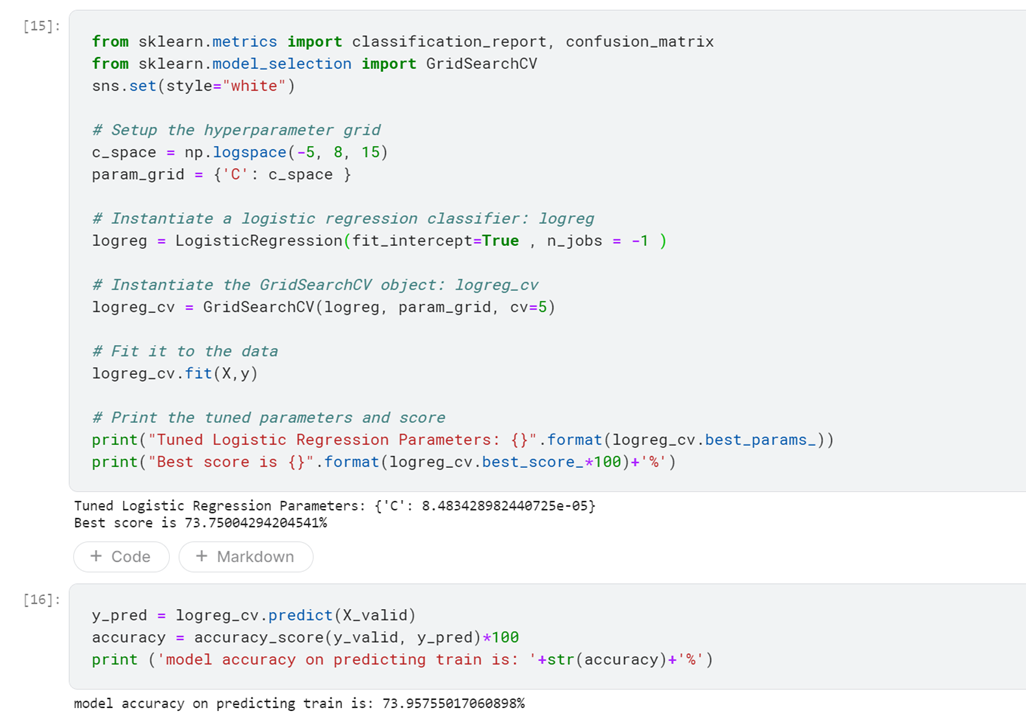!

In [21]:
logreg = LogisticRegression(fit_intercept=True , n_jobs = -1 , C = 8.483428982440725e-05)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 73.95176681510613%


# Logistic regression AUC Score

In [22]:
'''y_pred1 = logreg.predict_proba(X_valid)
auc = roc_auc_score(y_valid, y_pred1[:,1])
print('AUC valid: %.3f' % auc)
y_pred = logreg.predict_proba(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred[:,1])
print('AUC test: %.3f' % auc)'''

"y_pred1 = logreg.predict_proba(X_valid)\nauc = roc_auc_score(y_valid, y_pred1[:,1])\nprint('AUC valid: %.3f' % auc)\ny_pred = logreg.predict_proba(X_hold_out)\nauc = roc_auc_score(y_hold_out, y_pred[:,1])\nprint('AUC test: %.3f' % auc)"

In [23]:
y_logreg_prob = logreg.predict_proba(X)
y_logreg_prob_hold = logreg.predict_proba(X_hold_out)
y_logreg_prob_test = logreg.predict_proba(df_test)

> # KNN

In [24]:
'''from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
accs = []
for k in range(10,410):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Better to use knn.predict() but cuML v0.11.0 has bug
    # y_hat = knn.predict(X_test)
    y_hat_p = knn.predict_proba(X_valid)
    acc = (pd.DataFrame(y_hat_p,index=y_hat_p[:,0]).values.argmax(axis=1)==y_valid.to_numpy() ).sum()/y_valid.shape[0]
    #print(k,acc)
    print(k,', ',end='')
    accs.append(acc)'''

"from cuml.neighbors import KNeighborsClassifier, NearestNeighbors\naccs = []\nfor k in range(10,410):\n    knn = KNeighborsClassifier(n_neighbors=k)\n    knn.fit(X_train, y_train)\n    # Better to use knn.predict() but cuML v0.11.0 has bug\n    # y_hat = knn.predict(X_test)\n    y_hat_p = knn.predict_proba(X_valid)\n    acc = (pd.DataFrame(y_hat_p,index=y_hat_p[:,0]).values.argmax(axis=1)==y_valid.to_numpy() ).sum()/y_valid.shape[0]\n    #print(k,acc)\n    print(k,', ',end='')\n    accs.append(acc)"

In [25]:
'''plt.figure(figsize=(15,5))
plt.plot(range(10,410),accs)
plt.title('MNIST kNN k value versus validation acc')
plt.show()'''


"plt.figure(figsize=(15,5))\nplt.plot(range(10,410),accs)\nplt.title('MNIST kNN k value versus validation acc')\nplt.show()"

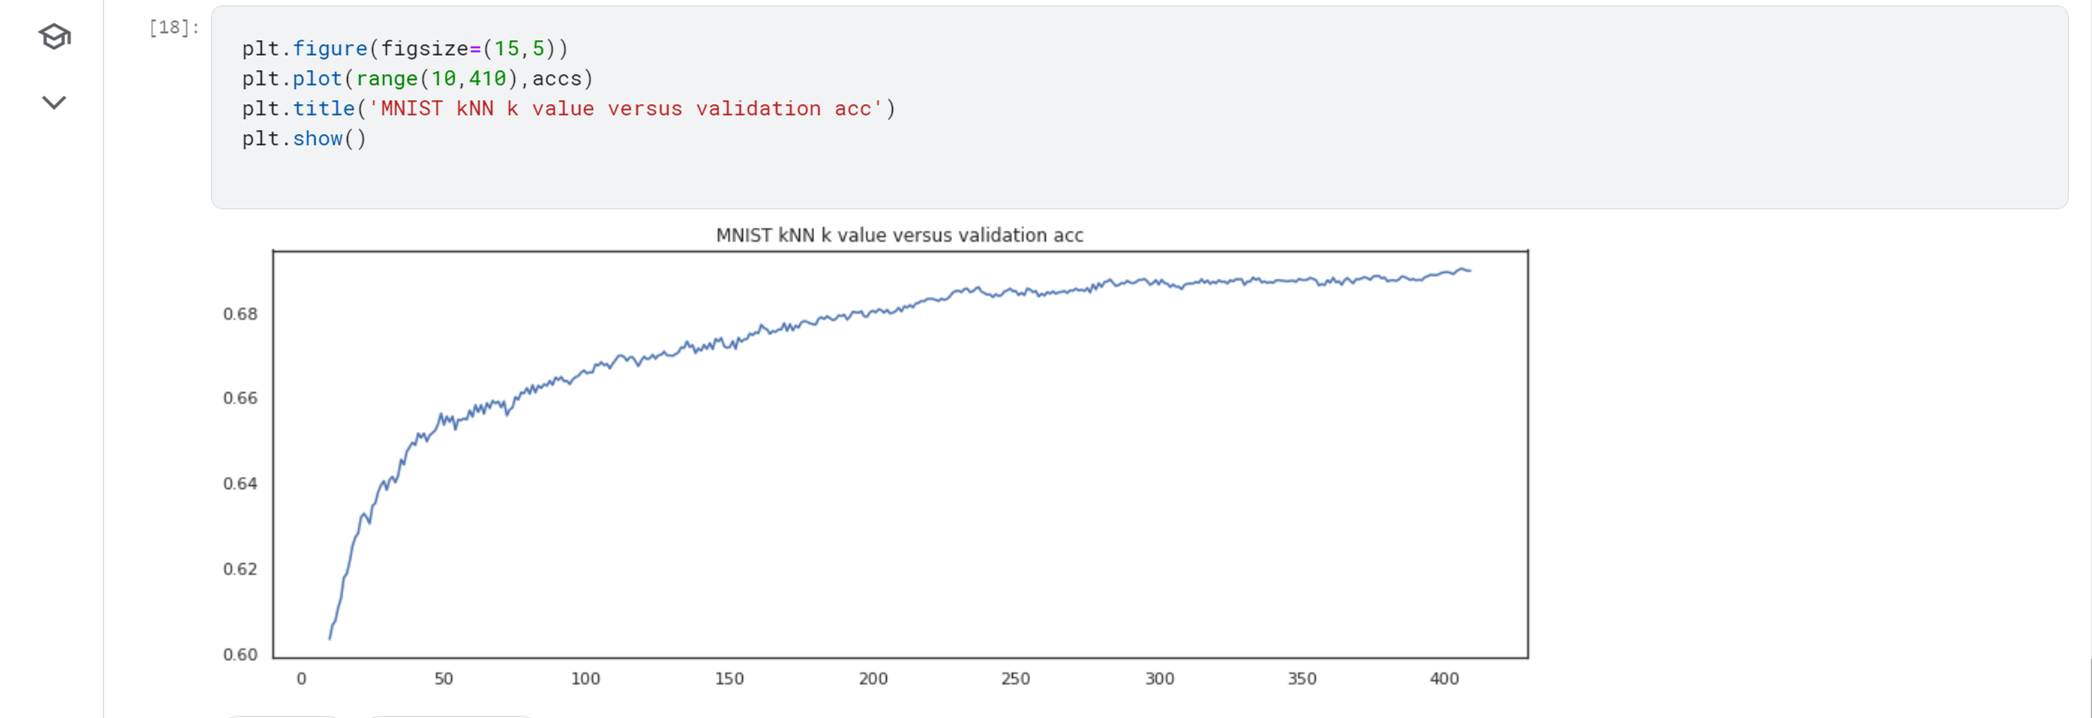!

In [26]:
knn = KNeighborsClassifier(n_neighbors= 406)
knn.fit(X_train, y_train)
y_hat_p = knn.predict(X_train)

> # KNN AUC SCORE

In [27]:
'''y_pred2 = knn.predict_proba(X_valid)
auc = roc_auc_score(y_valid, y_pred2[:,1])
print('AUC valid: %.3f' % auc)
y_pred = knn.predict_proba(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred[:,1])
print('AUC test: %.3f' % auc)'''

"y_pred2 = knn.predict_proba(X_valid)\nauc = roc_auc_score(y_valid, y_pred2[:,1])\nprint('AUC valid: %.3f' % auc)\ny_pred = knn.predict_proba(X_hold_out)\nauc = roc_auc_score(y_hold_out, y_pred[:,1])\nprint('AUC test: %.3f' % auc)"

In [28]:
y_knn_prob = knn.predict_proba(X)
y_knn_prob_hold = knn.predict_proba(X_hold_out)
y_knn_prob_test = knn.predict_proba(df_test)

> # Gaussian Naive Bayes 

In [29]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 59.55121161297785%


> # Gaussian Naive Bayes AUC Score

In [30]:
'''y_pred3 = gnb.predict_proba(X_valid)
auc = roc_auc_score(y_valid, y_pred3[:,1])
print('AUC valid: %.3f' % auc)
y_pred = gnb.predict_proba(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred[:,1])
print('AUC test: %.3f' % auc)'''

"y_pred3 = gnb.predict_proba(X_valid)\nauc = roc_auc_score(y_valid, y_pred3[:,1])\nprint('AUC valid: %.3f' % auc)\ny_pred = gnb.predict_proba(X_hold_out)\nauc = roc_auc_score(y_hold_out, y_pred[:,1])\nprint('AUC test: %.3f' % auc)"

In [31]:
y_gnb_prob = gnb.predict_proba(X)
y_gnb_prob_hold = gnb.predict_proba(X_hold_out)
y_gnb_prob_test = gnb.predict_proba(df_test)

In [32]:
col1 = pd.DataFrame(y_XGB_prob,index=X.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob,index=X.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_knn_prob,index=X.index)
col3.columns = ['KNNT', 'KNNF']
col4 = pd.DataFrame(y_gnb_prob,index=X.index)
col4.columns = ['GNBT', 'GNBF']

In [33]:
X = pd.concat([X,col1,col2,col3,col4], axis=1)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size = 0.0297,stratify=y)

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# we still need to clear a graph though

tf.keras.backend.clear_session()
model = keras.Sequential([
    layers.Dense(100, activation='swish', input_shape=[X.shape[1]]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='swish'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='swish'),
    layers.Dropout(0.3),
    # For a binary classification function use sigmoid
    layers.Dense(1, activation='sigmoid')])

2021-11-20 00:38:48.940305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 00:38:48.942440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 00:38:48.943420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-20 00:38:48.944582: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10900     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [37]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC'])

In [38]:
model.fit(
    X_train, 
    y_train,
    batch_size=1024, 
    epochs=10,
    validation_data=(X_valid, y_valid)
    ,
    verbose=0
)

2021-11-20 00:38:52.915359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 488064096 exceeds 10% of free system memory.
2021-11-20 00:38:53.399285: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 488064096 exceeds 10% of free system memory.
2021-11-20 00:38:53.800551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [39]:
y_pred = model.predict(X_valid)
for el in range(len(y_pred)):
    if y_pred[el] >= 0.5:
        y_pred[el] = 1 
    else:
        y_pred[el] = 0
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 74.46648545486092%


In [40]:
col1 = pd.DataFrame(y_XGB_prob_hold,index=X_hold_out.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob_hold,index=X_hold_out.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_knn_prob_hold,index=X_hold_out.index)
col3.columns = ['KNNT', 'KNNF']
col4 = pd.DataFrame(y_gnb_prob_hold,index=X_hold_out.index)
col4.columns = ['GNBT', 'GNBF']

In [41]:
X_hold_out = pd.concat([X_hold_out,col1,col2,col3,col4], axis=1)

In [42]:
'''y_pred = model.predict(X_valid)
auc = roc_auc_score(y_valid, y_pred)
print('AUC valid: %.3f' % auc)
y_pred = model.predict(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred)
print('AUC test: %.3f' % auc)'''

"y_pred = model.predict(X_valid)\nauc = roc_auc_score(y_valid, y_pred)\nprint('AUC valid: %.3f' % auc)\ny_pred = model.predict(X_hold_out)\nauc = roc_auc_score(y_hold_out, y_pred)\nprint('AUC test: %.3f' % auc)"

In [43]:
y_pred = model.predict(X)

2021-11-20 00:39:29.157151: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 503003520 exceeds 10% of free system memory.
2021-11-20 00:39:29.632018: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 503003520 exceeds 10% of free system memory.


In [44]:
col1 = pd.DataFrame(y_pred,index=X.index)
col1.columns = ['DeepT']
col2 = pd.DataFrame(1-y_pred,index=X.index)
col2.columns = ['DeepF']

In [45]:
X = pd.concat([X,col1,col2], axis=1)

In [46]:
y_pred = model.predict(X_hold_out)

In [47]:
col1 = pd.DataFrame(y_pred,index=X_hold_out.index)
col1.columns = ['DeepT']
col2 = pd.DataFrame(1-y_pred,index=X_hold_out.index)
col2.columns = ['DeepF']

In [48]:
X_hold_out = pd.concat([X_hold_out,col1,col2], axis=1)

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size = 0.0297,stratify=y)

In [50]:
accuracy = 0
while accuracy == 0 :
    try:
        modelxx = XGBClassifier(base_score=0.5, booster='gbtree' ,colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
                      gamma=0, gpu_id=-1, importance_type='gain',
                      interaction_constraints='', learning_rate= 0.75365952,
                      max_delta_step=0, max_depth= 2 ,
                      monotone_constraints='()', n_estimators= 300 , n_jobs=3,
                      num_parallel_tree=1,
                      reg_alpha= 0.1, reg_lambda= 0.5, 
                      tree_method='gpu_hist', 
                     )

    
    
        modelxx.fit(X_train, y_train)
        y_pred = modelxx.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)*100
        print ('model accuracy on predicting valid is: '+str(accuracy)+'%')
        y_pred = modelxx.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred)*100
        print ('model accuracy on predicting train is: '+str(accuracy)+'%')
    except:
        pass 
y_XGB_prob1 = modelxx.predict_proba(X_valid)
y_XGB_prob_hold = modelxx.predict_proba(X_hold_out)  
auc = roc_auc_score(y_valid, y_XGB_prob1[:,1])
print('AUC valid: %.3f' % auc)
auc = roc_auc_score(y_hold_out, y_XGB_prob_hold[:,1])
print('AUC test: %.3f' % auc)
#model.fit(X, y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model accuracy on predicting valid is: 74.41443525533515%
model accuracy on predicting train is: 74.60226699404662%
AUC valid: 0.758
AUC test: 0.762


In [51]:
col1 = pd.DataFrame(y_XGB_prob_test,index=df_test.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob_test,index=df_test.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_knn_prob_test,index=df_test.index)
col3.columns = ['KNNT', 'KNNF']
col4 = pd.DataFrame(y_gnb_prob_test,index=df_test.index)
col4.columns = ['GNBT', 'GNBF']

In [52]:
df_test = pd.concat([df_test,col1,col2,col3,col4], axis=1)

In [53]:
y_pred = model.predict(df_test)

2021-11-20 00:40:12.160483: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 466560000 exceeds 10% of free system memory.


In [54]:
col1 = pd.DataFrame(y_pred,index=df_test.index)
col1.columns = ['DeepT']
col2 = pd.DataFrame(1-y_pred,index=df_test.index)
col2.columns = ['DeepF']

In [55]:
df_test = pd.concat([df_test,col1,col2], axis=1)

In [56]:
logreg = LogisticRegression(fit_intercept=True , n_jobs = -1 , C = 8.483428982440725e-05)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 74.43178532184373%


In [57]:
y_pred1 = logreg.predict_proba(X_valid)
auc = roc_auc_score(y_valid, y_pred1[:,1])
print('AUC valid: %.3f' % auc)
y_pred = logreg.predict_proba(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred[:,1])
print('AUC test: %.3f' % auc)

AUC valid: 0.748
AUC test: 0.753


In [58]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 70.95598866462322%


In [59]:
y_pred3 = gnb.predict_proba(X_valid)
auc = roc_auc_score(y_valid, y_pred3[:,1])
print('AUC valid: %.3f' % auc)
y_pred = gnb.predict_proba(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred[:,1])
print('AUC test: %.3f' % auc)

AUC valid: 0.724
AUC test: 0.723


In [60]:
y_XGB_prob = modelxx.predict_proba(X)
y_XGB_prob_hold = modelxx.predict_proba(X_hold_out)
y_XGB_prob_test = modelxx.predict_proba(df_test)
y_logreg_prob = logreg.predict_proba(X)
y_logreg_prob_hold = logreg.predict_proba(X_hold_out)
y_logreg_prob_test = logreg.predict_proba(df_test)
y_gnb_prob = gnb.predict_proba(X)
y_gnb_prob_hold = gnb.predict_proba(X_hold_out)
y_gnb_prob_test = gnb.predict_proba(df_test)

In [61]:
col1 = pd.DataFrame(y_XGB_prob,index=X.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob,index=X.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_gnb_prob,index=X.index)
col3.columns = ['GNBT', 'GNBF']

In [62]:
X = pd.concat([X,col1,col2,col3], axis=1)

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size = 0.0297,stratify=y)

In [64]:
tf.keras.backend.clear_session()
model = keras.Sequential([
    layers.Dense(100, activation='swish', input_shape=[X.shape[1]]),
    layers.Dropout(0.3),
    layers.Dense(64, activation='swish'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='swish'),
    layers.Dropout(0.3),
    # For a binary classification function use sigmoid
    layers.Dense(1, activation='sigmoid')])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11700     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [66]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['AUC'])

In [67]:
model.fit(
    X_train, 
    y_train,
    batch_size=1024, 
    epochs=10,
    validation_data=(X_valid, y_valid)
    ,
    verbose=0
)

In [68]:
y_pred = model.predict(X_valid)
for el in range(len(y_pred)):
    if y_pred[el] >= 0.5:
        y_pred[el] = 1 
    else:
        y_pred[el] = 0
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_valid, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')

model accuracy on predicting train is: 74.3450349893008%


In [69]:
col1 = pd.DataFrame(y_XGB_prob_hold,index=X_hold_out.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob_hold,index=X_hold_out.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_gnb_prob_hold,index=X_hold_out.index)
col3.columns = ['GNBT', 'GNBF']

In [70]:
X_hold_out = pd.concat([X_hold_out,col1,col2,col3], axis=1)

In [71]:
col1 = pd.DataFrame(y_XGB_prob_test,index=df_test.index)
col1.columns = ['XGBT', 'XGBF']
col2 = pd.DataFrame(y_logreg_prob_test,index=df_test.index)
col2.columns = ['logregT', 'logregF']
col3 = pd.DataFrame(y_gnb_prob_test,index=df_test.index)
col3.columns = ['GNBT', 'GNBF']

In [72]:
df_test = pd.concat([df_test,col1,col2,col3], axis=1)

In [73]:
y_pred = model.predict(X_valid)
auc = roc_auc_score(y_valid, y_pred)
print('AUC valid: %.3f' % auc)
y_pred = model.predict(X_hold_out)
auc = roc_auc_score(y_hold_out, y_pred)
print('AUC test: %.3f' % auc)

AUC valid: 0.756
AUC test: 0.759


In [74]:
y_pred = model.predict(df_test)


In [75]:
'''y_pred = model.predict(X_hold_out)
for el in range(len(y_pred)):
    if y_pred[el] >= 0.5:
        y_pred[el] = 1 
    else:
        y_pred[el] = 0
y_pred = y_pred.astype(int)
accuracy = accuracy_score(y_hold_out, y_pred)*100
print ('model accuracy on predicting train is: '+str(accuracy)+'%')'''

"y_pred = model.predict(X_hold_out)\nfor el in range(len(y_pred)):\n    if y_pred[el] >= 0.5:\n        y_pred[el] = 1 \n    else:\n        y_pred[el] = 0\ny_pred = y_pred.astype(int)\naccuracy = accuracy_score(y_hold_out, y_pred)*100\nprint ('model accuracy on predicting train is: '+str(accuracy)+'%')"

In [76]:
#y_pred = (y_pred_ref + y_gnb_prob_test[:,1] + y_knn_prob_test[:,1] + y_XGB_prob_test[:,1] + y_logreg_prob_test[:,1])/5

In [77]:
sub_df = pd.read_csv("../input/tabular-playground-series-nov-2021/sample_submission.csv")
sub_df['target'] = y_pred
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,target
0,600000,0.783925
1,600001,0.556811
2,600002,0.714864
3,600003,0.294590
4,600004,0.724922
